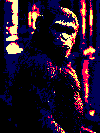

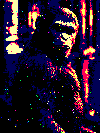


Достигнуто максимальное число поколений

=== Результаты ===
Размер матрицы: (133, 100)
Цветов в палитре: 16
Тип расстояния: Хэмминга
Размер популяции: 50
Всего поколений: 40000
Лучшее расстояние: 133.0

Целевое изображение:

Финальный результат:

Процесс эволюции (только улучшения):
GIF сохранен как: c:\Users\Golum\Desktop\iu9-education\optimization-methods\lab13\evolution.gif

График изменения расстояния:


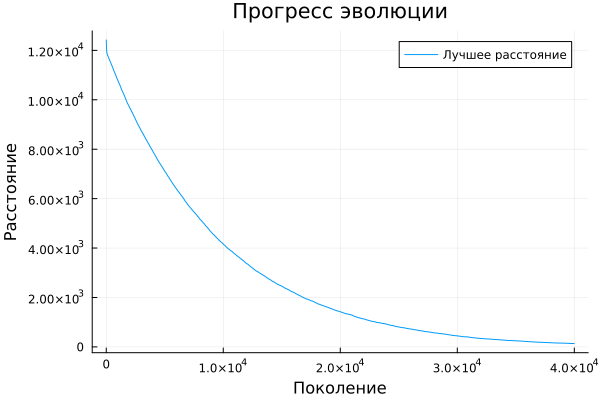

([12420.0, 12405.0, 12373.0, 12352.0, 12351.0, 12319.0, 12308.0, 12293.0, 12276.0, 12268.0  …  142.0, 141.0, 140.0, 139.0, 138.0, 137.0, 136.0, 135.0, 134.0, 133.0], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  39548, 39561, 39616, 39642, 39837, 39926, 39963, 39980, 39984, 39986])

In [3]:
using Images
using FileIO
using Base64
using Statistics
using ColorSchemes
using Plots

function get_palette(palette_bits=12)
    n_colors = 2^palette_bits
    color_step = 1 / (2^(palette_bits÷3) - 1)
    
    r_bits = palette_bits ÷ 3
    g_bits = palette_bits ÷ 3
    b_bits = palette_bits - r_bits - g_bits
    
    palette = Vector{RGB{Float64}}(undef, n_colors)
    index = 1
    
    for r in 0:(2^r_bits-1)
        for g in 0:(2^g_bits-1)
            for b in 0:(2^b_bits-1)
                palette[index] = RGB(r/(2^r_bits-1), g/(2^g_bits-1), b/(2^b_bits-1))
                index += 1
            end
        end
    end
    
    return palette
end

function image_to_matrix(img_path, palette_bits=12)
    img = load(img_path)
    palette = get_palette(palette_bits)
    n_colors = length(palette)
    
    r_bits = palette_bits ÷ 3
    g_bits = palette_bits ÷ 3
    b_bits = palette_bits - r_bits - g_bits
    
    img_indices = zeros(Int, size(img))
    
    for i in 1:size(img, 1), j in 1:size(img, 2)
        c = img[i,j]
        r, g, b = red(c), green(c), blue(c)
        
        r_idx = round(Int, r * (2^r_bits - 1))
        g_idx = round(Int, g * (2^g_bits - 1))
        b_idx = round(Int, b * (2^b_bits - 1))
        
        idx = (r_idx << (g_bits + b_bits)) | (g_idx << b_bits) | b_idx + 1
        img_indices[i,j] = clamp(idx, 1, n_colors)
    end
    
    return img_indices
end

function matrix_to_image(matrix, palette_bits=12)
    palette = get_palette(palette_bits)
    h, w = size(matrix)
    img = Array{RGB{Float64}}(undef, h, w)
    for i in 1:h, j in 1:w
        idx = clamp(matrix[i, j], 1, length(palette))
        img[i, j] = palette[idx]
    end
    return img
end

function crossover_matrix(a::Matrix{Int}, b::Matrix{Int})
    child = similar(a)
    for i in eachindex(a)
        child[i] = rand() < 0.5 ? a[i] : b[i]
    end
    return child
end

function mutate_matrix(mat::Matrix{Int}, mutation_rate::Float64, max_val::Int)
    mutated = copy(mat)
    for i in eachindex(mutated)
        rand() < mutation_rate && (mutated[i] = rand(1:max_val))
    end
    return mutated
end

function calculate_distance(a, b, use_hamming)
    if use_hamming
        return sum(a .!= b)
    else
        return sqrt(sum((a .- b).^2))
    end
end

function show_gif(frames, fps=5)
    temp_file = "evolution.gif"
    save(temp_file, cat(frames..., dims=3); fps=fps)
    println("GIF сохранен как: ", abspath(temp_file))
    return nothing
end

function run_single_experiment(target_image_path; 
                             max_generations=500,
                             population_size=50,
                             mutation_rate=0.05,
                             epsilon=0.01,
                             tournament_size=3,
                             use_hamming=false,
                             show_progress=true,
                             palette_bits=4,
                             save_frame_step=100,
                             fps=5)
    
    palette = get_palette(palette_bits)
    bits_per_element = palette_bits
    reference = image_to_matrix(target_image_path, palette_bits)
    matrix_size = size(reference)
    
    population = [rand(1:length(palette), matrix_size) for _ in 1:population_size]
    best_individual = copy(population[1])
    best_distance = Inf
    frames = []
    distance_history = Float64[]
    improvement_generations = Int[]
    
    fitness(individual) = calculate_distance(individual, reference, use_hamming)
    
    function tournament_selection(pop, fitnesses)
        candidates = rand(1:length(pop), tournament_size)
        winner = argmin(fitnesses[candidates])
        return pop[candidates[winner]]
    end
    
    for generation in 1:max_generations
        fitnesses = [fitness(ind) for ind in population]
        
        current_best_idx = argmin(fitnesses)
        current_best = population[current_best_idx]
        current_dist = fitnesses[current_best_idx]
        
        if current_dist < best_distance
            best_individual = copy(current_best)
            best_distance = current_dist
            if (generation % save_frame_step == 0)
                push!(frames, matrix_to_image(best_individual, palette_bits))
            end
            push!(distance_history, best_distance)
            push!(improvement_generations, generation)
            
            if show_progress
                println("Поколение $generation: расстояние = $(round(best_distance, digits=4))")
            end
        end
        
        if best_distance <= epsilon
            println("\nДостигнута достаточная точность на поколении $generation")
            break
        end
        
        new_population = []

        push!(new_population, best_individual)
        
        while length(new_population) < population_size
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            child = mutate_matrix(crossover_matrix(parent1, parent2), mutation_rate, length(palette))
            push!(new_population, child)
        end
        
        population = new_population
        
        if generation == max_generations
            println("\nДостигнуто максимальное число поколений")
        end
    end
    
    println("\n=== Результаты ===")
    println("Размер матрицы: ", matrix_size)
    println("Цветов в палитре: ", 2^palette_bits)
    println("Тип расстояния: ", use_hamming ? "Хэмминга" : "Евклидово")
    println("Размер популяции: ", population_size)
    println("Всего поколений: ", max_generations)
    # println("Поколений с улучшениями: ", length(improvement_generations))
    println("Лучшее расстояние: ", round(best_distance, digits=4))
    
    println("\nЦелевое изображение:")
    display(matrix_to_image(reference, palette_bits))
    
    println("\nФинальный результат:")
    display(matrix_to_image(best_individual, palette_bits))
    
    if !isempty(frames)
        println("\nПроцесс эволюции (только улучшения):")
        show_gif(frames, fps)
    end
    
    if !isempty(distance_history)
        println("\nГрафик изменения расстояния:")
        plot(improvement_generations, distance_history, 
             xlabel="Поколение", ylabel="Расстояние",
             label="Лучшее расстояние", title="Прогресс эволюции")
        display(plot!())
    end
    
    return (distance_history, improvement_generations)
end

target_image = "image_100x133.jpg"
if isfile(target_image)
    run_single_experiment(target_image,
                        palette_bits=4,
                        max_generations=40000,
                        population_size=50,
                        epsilon=0.01,
                        tournament_size=3,
                        use_hamming=true,
                        mutation_rate=0.0001,
                        show_progress=false,
                        save_frame_step=100,
                        fps=20)
else
    println("Файл $target_image не найден!")
end